# RL tabular MM analysis
Set parameters, optionally run `mm_compare` with `--mm-type rl_tabular`, then plot PnL, rewards, actions, inventory, and spread.

In [28]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

# ---- parameters ----
run_simulation = True  # set True to launch a run from the notebook
run_simple_simulation = True  # set True to run simple MM
seed = 128475
ticker = 'AAPL'
historical_date = '20000101'
start_time = '00:00:01'
end_time = '23:59:00'
mm_type = 'rl_tabular'
simple_mm_type = 'simple'
log_name = f'rl_tabular_seed_{seed}'
simple_log_name = f'simple_seed_{seed}'
repo_root = Path('..')
log_dir = repo_root / 'log' / log_name
simple_log_dir = repo_root / 'log' / simple_log_name
# --------------------

print('Log dir:', log_dir.resolve())
print('Simple log dir:', simple_log_dir.resolve())


Log dir: /Users/salim/Desktop/Columbia/Assignments_Columbia/S3/Reinforcement Learning/Project/ABIDES/abides/log/rl_tabular_seed_128475
Simple log dir: /Users/salim/Desktop/Columbia/Assignments_Columbia/S3/Reinforcement Learning/Project/ABIDES/abides/log/simple_seed_128475


## Run simulation (optional)

In [29]:
if run_simulation:
    cmd = [
        'python', 'abides.py',
        '-c', 'mm_compare',
        '-t', ticker,
        '-d', historical_date,
        '--start-time', start_time,
        '--end-time', end_time,
        '--seed', str(seed),
        '--log_dir', log_name,
        '--mm-type', mm_type,
    ]
    print('Running RL tabular:', ' '.join(cmd))
    result = subprocess.run(cmd, cwd=repo_root)
    print('Return code:', result.returncode)
else:
    print('Skipping RL simulation; set run_simulation=True to execute.')

if run_simple_simulation:
    cmd_simple = [
        'python', 'abides.py',
        '-c', 'mm_compare',
        '-t', ticker,
        '-d', historical_date,
        '--start-time', start_time,
        '--end-time', end_time,
        '--seed', str(seed),
        '--log_dir', simple_log_name,
        '--mm-type', simple_mm_type,
    ]
    print('Running simple MM:', ' '.join(cmd_simple))
    result_simple = subprocess.run(cmd_simple, cwd=repo_root)
    print('Return code simple:', result_simple.returncode)
else:
    print('Skipping simple MM run; set run_simple_simulation=True to execute.')


Running RL tabular: python abides.py -c mm_compare -t AAPL -d 20000101 --start-time 00:00:01 --end-time 23:59:00 --seed 128475 --log_dir rl_tabular_seed_128475 --mm-type rl_tabular
ABIDES: Agent-Based Interactive Discrete Event Simulation

Simulation Start Time: 2025-12-01 16:06:33.035330
Configuration seed: 128475


--- Simulation time: 2000-01-01 00:00:00, messages processed: 0, wallclock elapsed: 0 days 00:00:00.000006 ---


--- Simulation time: 2000-01-01 03:26:08.914148091, messages processed: 100000, wallclock elapsed: 0 days 00:00:03.963222 ---


--- Simulation time: 2000-01-01 06:49:31.484025321, messages processed: 200000, wallclock elapsed: 0 days 00:00:08.541815 ---


--- Simulation time: 2000-01-01 10:16:31.456095440, messages processed: 300000, wallclock elapsed: 0 days 00:00:14.533157 ---


--- Simulation time: 2000-01-01 13:41:40.145036093, messages processed: 400000, wallclock elapsed: 0 days 00:00:20.478736 ---


--- Simulation time: 2000-01-01 17:09:17.520042080, mess

Processing orderbook log: 100%|██████████| 84300/84300 [00:02<00:00, 37493.95it/s]


Order book logging complete!
Time taken to log the order book: 0:00:07.193056
Order book archival complete.
Event Queue elapsed: 0 days 00:00:43.096890, messages: 697858, messages per second: 16192.8
Mean ending value by agent type:
ValueAgent: 36743364
RLTabularMarketMakerAgent: -183716818
Simulation ending!
Simulation End Time: 2025-12-01 16:07:28.176753
Time taken to run simulation: 0:00:55.141423
Return code: 0
Running simple MM: python abides.py -c mm_compare -t AAPL -d 20000101 --start-time 00:00:01 --end-time 23:59:00 --seed 128475 --log_dir simple_seed_128475 --mm-type simple
ABIDES: Agent-Based Interactive Discrete Event Simulation

Simulation Start Time: 2025-12-01 16:07:30.386849
Configuration seed: 128475


--- Simulation time: 2000-01-01 00:00:00, messages processed: 0, wallclock elapsed: 0 days 00:00:00.000036 ---


--- Simulation time: 2000-01-01 03:34:52.926892238, messages processed: 100000, wallclock elapsed: 0 days 00:00:03.951204 ---


--- Simulation time: 2000-01-0

Processing orderbook log: 100%|██████████| 88186/88186 [00:02<00:00, 38108.89it/s]


Order book logging complete!
Time taken to log the order book: 0:00:07.707339
Order book archival complete.
Event Queue elapsed: 0 days 00:00:41.316704, messages: 671966, messages per second: 16263.8
Mean ending value by agent type:
ValueAgent: 39375842
MarketMakerAgent: -196879208
Simulation ending!
Simulation End Time: 2025-12-01 16:08:24.347993
Time taken to run simulation: 0:00:53.961144
Return code simple: 0


## Load logs

In [ ]:
# RL
-183716818 

# Simple
-196879208

In [30]:
summary_path = log_dir / 'summary_log.bz2'
orderbook_file = next(log_dir.glob('ORDERBOOK_*_FULL.bz2'), None)
if not summary_path.exists():
    raise FileNotFoundError(summary_path)

summary = pd.read_pickle(summary_path)
summary.head()

,AgentID,AgentStrategy,EventType,Event
0,1,ValueAgent,STARTING_CASH,10000000.0
1,2,ValueAgent,STARTING_CASH,10000000.0
2,3,ValueAgent,STARTING_CASH,10000000.0
3,4,ValueAgent,STARTING_CASH,10000000.0
4,5,ValueAgent,STARTING_CASH,10000000.0


### Summary PnL by strategy

In [31]:
wide = summary.pivot_table(index=['AgentID', 'AgentStrategy'], columns='EventType', values='Event', aggfunc='first')
wide['PNL'] = wide['ENDING_CASH'] - wide['STARTING_CASH']
wide.reset_index().sort_values('PNL', ascending=False).head(10)

EventType,AgentID,AgentStrategy,ENDING_CASH,FINAL_CASH_POSITION,FINAL_VALUATION,STARTING_CASH,PNL
3,4,ValueAgent,58497936.0,-7.377730e+08,-73.976717,10000000.0,48497936.0
2,3,ValueAgent,56801583.0,-5.539681e+08,-55.785256,10000000.0,46801583.0
1,2,ValueAgent,51208266.0,-5.052954e+08,-50.973581,10000000.0,41208266.0
0,1,ValueAgent,35659824.0,-4.189566e+08,-42.439774,10000000.0,25659824.0
4,5,ValueAgent,31549209.0,-3.288215e+08,-33.515219,10000000.0,21549209.0
5,6,RLTabularMarketMakerAgent,-173716818.0,2.604815e+09,NaN,10000000.0,-183716818.0


## RL tabular agent log

In [32]:
rl_files = list(log_dir.glob('RL_TABULAR_MARKET_MAKER_AGENT_*.bz2'))
if not rl_files:
    raise FileNotFoundError('No RL_TABULAR_MARKET_MAKER_AGENT logs found')
rl_log = pd.read_pickle(rl_files[0])
print('RL log columns:', list(rl_log.columns))
rl_log.head()

RL log columns: ['EventType', 'Event']


,EventType,Event
EventTime,,
NaT,AGENT_TYPE,RLTabularMarketMakerAgent
NaT,STARTING_CASH,10000000
2000-01-01 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 10000000}
2000-01-01 00:00:04.012005870,BID_DEPTH,"[(100004, 7)]"
2000-01-01 00:00:04.012005870,ASK_DEPTH,[]


### Simple MM log


In [33]:
simple_files = list(simple_log_dir.glob('MARKET_MAKER_AGENT_*.bz2'))
if simple_files:
    simple_log = pd.read_pickle(simple_files[0])
    print('Simple MM log columns:', list(simple_log.columns))
    simple_state_rows = simple_log[simple_log['EventType'] == 'STATE']
else:
    simple_state_rows = pd.DataFrame()
    print('No simple MM log found')


Simple MM log columns: ['EventType', 'Event']


### MTM comparison (RL vs simple)


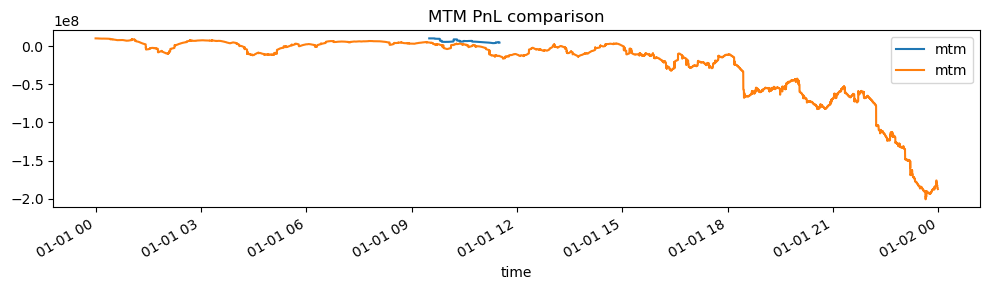

In [34]:
# MTM comparison (aligned on time index)
if 'state_rows' not in globals():
    rl_files = list(log_dir.glob('RL_TABULAR_MARKET_MAKER_AGENT_*.bz2'))
    rl_log = pd.read_pickle(rl_files[0]) if rl_files else pd.DataFrame()
    state_rows = rl_log[rl_log['EventType'] == 'STATE'] if not rl_log.empty else pd.DataFrame()
if 'simple_state_rows' not in globals():
    simple_files = list(simple_log_dir.glob('MARKET_MAKER_AGENT_*.bz2'))
    simple_log = pd.read_pickle(simple_files[0]) if simple_files else pd.DataFrame()
    simple_state_rows = simple_log[simple_log['EventType'] == 'STATE'] if not simple_log.empty else pd.DataFrame()

if not state_rows.empty and not simple_state_rows.empty:
    rl_state = pd.DataFrame(list(state_rows['Event'])).set_index('time')
    rl_state.index = pd.to_datetime(rl_state.index)
    simple_state = pd.DataFrame(list(simple_state_rows['Event'])).set_index('time')
    simple_state.index = pd.to_datetime(simple_state.index)
    df = pd.concat([rl_state['mtm'].rename('rl_tabular'), simple_state['mtm'].rename('simple')], axis=1)
    df = df.sort_index()
    # resample to 1-minute grid for alignment (adjust freq if needed)
    df_resampled = df.resample('1T').last()
    ax = df_resampled.plot(figsize=(10,3), title='MTM PnL comparison')
    plt.legend()
    plt.tight_layout()
else:
    print('Missing STATE events for RL or simple MM')


### Inventory comparison (RL vs simple)


In [ ]:
# Plot inventories on common time grid
# Recompute from logs to avoid re-use issues
rl_files = list(log_dir.glob('RL_TABULAR_MARKET_MAKER_AGENT_*.bz2'))
rl_log = pd.read_pickle(rl_files[0]) if rl_files else pd.DataFrame()
state_rows_rl = rl_log[rl_log['EventType'] == 'STATE'] if not rl_log.empty else pd.DataFrame()
simple_files = list(simple_log_dir.glob('MARKET_MAKER_AGENT_*.bz2'))
simple_log = pd.read_pickle(simple_files[0]) if simple_files else pd.DataFrame()
state_rows_simple = simple_log[simple_log['EventType'] == 'STATE'] if not simple_log.empty else pd.DataFrame()

if not state_rows_rl.empty and not state_rows_simple.empty:
    rl_state = pd.DataFrame(list(state_rows_rl['Event'])).set_index('time')
    rl_state.index = pd.to_datetime(rl_state.index)
    simple_state = pd.DataFrame(list(state_rows_simple['Event'])).set_index('time')
    simple_state.index = pd.to_datetime(simple_state.index)
    # plot raw inventories
    ax = rl_state[['inventory']].plot(figsize=(10,3), title='Inventory comparison (raw)', label='rl_tabular')
    simple_state[['inventory']].plot(ax=ax, label='simple')
    plt.legend()
    plt.tight_layout()
    # aligned on 1-minute grid
    df = pd.concat([rl_state['inventory'].rename('rl_tabular'), simple_state['inventory'].rename('simple')], axis=1)
    df = df.sort_index()
    df_resampled = df.resample('1T').last()
    df_resampled.plot(figsize=(10,3), title='Inventory comparison (1-minute resampled)')
    plt.legend()
    plt.tight_layout()
else:
    print('Missing STATE events for RL or simple MM')


### Inventory, cash, MTM, spread, actions

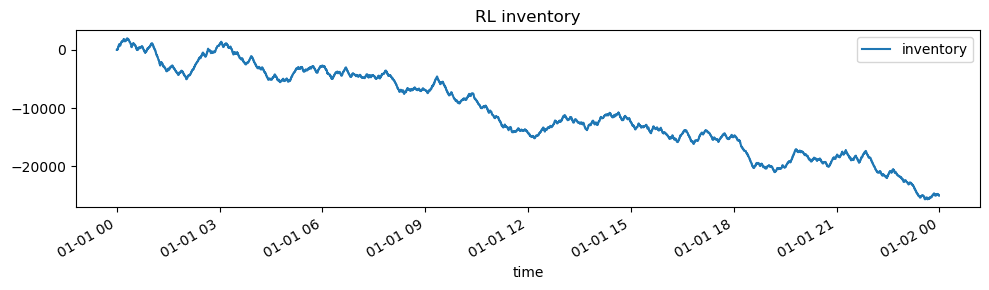

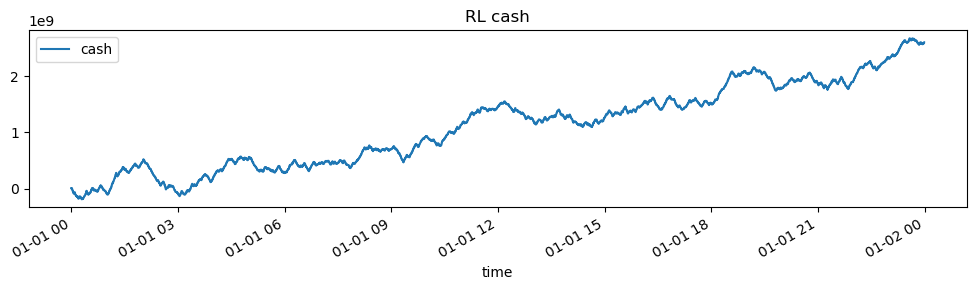

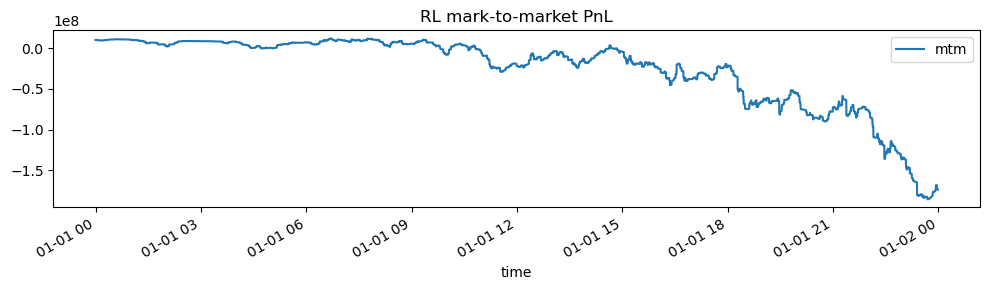

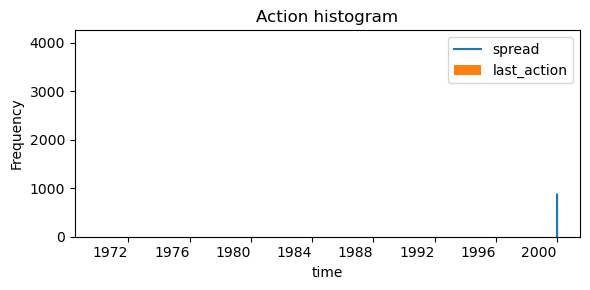

In [35]:
state_rows = rl_log[rl_log['EventType'] == 'STATE']
if not state_rows.empty:
    state_df = pd.DataFrame(list(state_rows['Event']))
    state_df = state_df.set_index('time')
    state_df.index = pd.to_datetime(state_df.index)
    state_df[['inventory']].plot(figsize=(10,3), title='RL inventory', legend=True)
    plt.tight_layout()
    state_df[['cash']].plot(figsize=(10,3), title='RL cash', legend=True)
    plt.tight_layout()
    state_df[['mtm']].plot(figsize=(10,3), title='RL mark-to-market PnL', legend=True)
    plt.tight_layout()
    state_df[['spread']].plot(figsize=(10,3), title='Spread observed by RL', legend=True)
    plt.tight_layout()
    state_df['last_action'].plot(kind='hist', bins=10, figsize=(6,3), title='Action histogram', label='last_action')
    plt.legend()
    plt.tight_layout()
else:
    print('No STATE events found in RL log')

### Rewards and PnL per step

In [ ]:
if not state_rows.empty:
    # Plot step reward
    state_df['reward'].plot(figsize=(10,3), title='Step reward', label='reward')
    plt.legend()
    plt.tight_layout()

    # Plot reward rolling mean (100)
    state_df['reward'].rolling(window=100).mean().plot(figsize=(10,3), title='Reward rolling mean (100)', label='reward_roll100')
    plt.legend()
    plt.tight_layout()

    # Plot cumulative reward
    state_df['cum_reward'].plot(figsize=(10,3), title='Cumulative reward', label='cum_reward')
    plt.legend()
    plt.tight_layout()

else:
    print('No STATE events found in RL log')


### Actions over time and Q proxy

In [ ]:
if not state_rows.empty:
    action_share = state_df['last_action'].resample('5T').apply(lambda s: s.value_counts()).unstack(fill_value=0)
    action_share.columns = [f'action_{c}' for c in action_share.columns]
    ax = action_share.plot.area(figsize=(10,3), title='Action counts per 5 min')
    plt.legend(title='action')
    plt.tight_layout()
else:
    print('No STATE events found in RL log')


### State visitation heatmap

In [ ]:
if not state_rows.empty:
    visit = state_df.groupby(['inventory_bin', 'spread_bin']).size().unstack(fill_value=0)
    plt.figure(figsize=(6,4))
    plt.imshow(visit, origin='lower', aspect='auto')
    plt.colorbar(label='visits')
    plt.xlabel('spread_bin')
    plt.ylabel('inventory_bin')
    plt.title('State visitation')
    plt.tight_layout()
else:
    print('No STATE events found in RL log')

## Order book and fundamental

In [ ]:
if orderbook_file:
    orderbook = pd.read_pickle(orderbook_file)
    print('Orderbook columns:', list(orderbook.columns))
    def find_col(columns, substrings):
        for col in columns:
            name = ' '.join(col) if isinstance(col, tuple) else str(col)
            lname = name.lower()
            if all(sub in lname for sub in substrings):
                return col
        return None
    bid_price_col = find_col(orderbook.columns, ['best', 'bid']) or find_col(orderbook.columns, ['bid', 'price'])
    ask_price_col = find_col(orderbook.columns, ['best', 'ask']) or find_col(orderbook.columns, ['ask', 'price'])
    if bid_price_col and ask_price_col:
        top = orderbook[[bid_price_col, ask_price_col]].copy()
        top.columns = ['best_bid_price', 'best_ask_price']
        top['mid'] = (top['best_bid_price'] + top['best_ask_price']) / 2
        top['spread'] = top['best_ask_price'] - top['best_bid_price']
        top[['mid']].plot(figsize=(10,3), title='Mid price', legend=True)
        plt.tight_layout()
        top[['spread']].plot(figsize=(10,3), title='Quoted spread', legend=True)
        plt.tight_layout()
    else:
        display(orderbook.head())
else:
    print('Orderbook file not found')

fund_file = next(log_dir.glob('fundamental_*.bz2'), None)
if fund_file:
    fundamental = pd.read_pickle(fund_file).reset_index()
    fundamental.plot(x='FundamentalTime', y='FundamentalValue', legend=True, figsize=(10,3), title='Fundamental path')
    plt.tight_layout()
else:
    print('Fundamental file not found')

### Q-values over time


In [ ]:
if not state_rows.empty and 'q_max' in state_df.columns:
    state_df['q_max'].plot(figsize=(10,3), title='Max Q for current state', label='q_max')
    plt.legend()
    plt.tight_layout()
    if 'greedy_action' in state_df.columns:
        state_df['greedy_action'].plot(figsize=(10,3), title='Greedy action over time', label='greedy_action')
        plt.legend()
        plt.tight_layout()
else:
    print('No Q info in STATE events')
